In [1]:
import json
import os
import sys  
sys.path.insert(0, '..')
import models
import config
import numpy as np

from tensorflow.keras import layers
from yolo import Yolo



2021-11-29 11:10:29.388862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-29 11:10:29.388893: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
weight_path = os.path.join('..', 'assets', 'model-new-test.525-35.48.h5')
val_notation = os.path.join('..', 'assets', 'validation.txt')
train_notation = os.path.join('..', 'assets', 'training.txt')
class_name = os.path.join('..', 'assets', 'class_name.txt')

In [10]:
model = Yolo(class_name, config.config, weight_path)

2021-11-29 11:14:46.020311: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-29 11:14:46.020414: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ozmonday): /proc/driver/nvidia/version does not exist
2021-11-29 11:14:46.020941: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


load from ../assets/model-new-test.525-35.48.h5


NotImplementedError: Cannot convert a symbolic Tensor (lambda/Exp:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

# of bboxes: 12


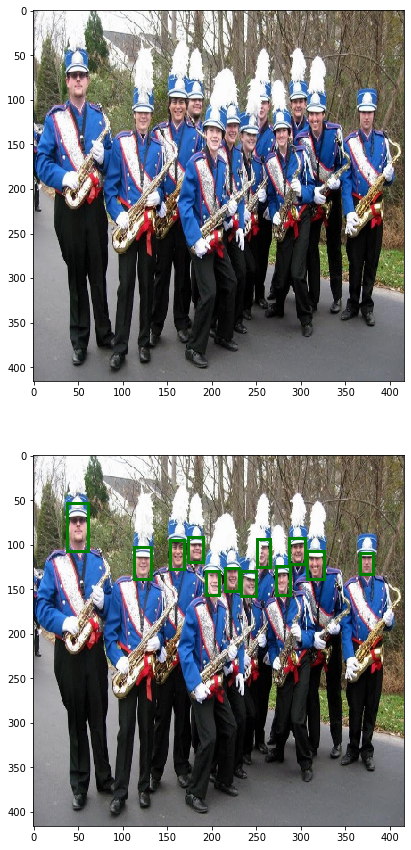

In [7]:
model.predict('../test_img/0_Parade_marchingband_1_187.jpg')

In [9]:
with open(val_notation) as json_file:
    datajson = json.load(json_file)

In [12]:
mnetinputsone = layers.Input((608, 608, 3))

mobilenet = models.MobileNet(mnetinputsone)
mobilenet.summary()


Model: "mobilenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 608, 608, 3)]     0         
_________________________________________________________________
conv_block_0 (Conv2D)        (None, 304, 304, 32)      864       
_________________________________________________________________
conv_block_0_bn (BatchNormal (None, 304, 304, 32)      128       
_________________________________________________________________
conv_block_0_relu (ReLU)     (None, 304, 304, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 304, 304, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 304, 304, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 304, 304, 32)      0 

In [3]:
mnetinputstwo = layers.Input((608, 606, 3))

mobilenetv2 = models.MobileNetV2(mnetinputstwo)
#mobilenetv2.summary()

2021-11-18 21:32:45.444875: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-18 21:32:45.444921: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ozmonday): /proc/driver/nvidia/version does not exist
2021-11-18 21:32:45.445353: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(None, 33, 33, 64)
(None, 12, 12, 1280)


In [26]:
arr = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
arr = arr.reshape((5,2))
print(arr.shape[0] != arr.shape[1])


inp = layers.Input((25, 25, 3))
print(inp.shape[1] == inp.shape[2])


for i in range(0, 4, 4):
  print(i)

True
True
0
